In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


In [2]:
/bin/rm -rf 4977
download_chandra_obsid 4977 --exclude vvref,evt2,osol,eph1
chandra_repro 4977 out=`pwd` clob+


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits      206 Mb  ####################            4 s  47330.7 kb/s
  asol     fits       17 Mb  ####################          < 1 s  76715.2 kb/s
  mtl      fits        3 Mb  ####################          < 1 s  52230.6 kb/s
  stat     fits        3 Mb  ####################          < 1 s  53845.3 kb/s
  aqual    fits        1 Mb  ####################          < 1 s  33873.8 kb/s
  cntr_img jpg       638 Kb  ####################          < 1 s  16360.2 kb/s
  bias     fits      498 Kb  ####################          < 1 s  17035.6 kb/s
  bias     fits      446 Kb  ####################          < 1 s  14969.7 kb/s
  bias     fits      439 Kb  ####################          < 1 s  18256.1 kb/s
  bias     fits      425 Kb  ####################          < 1 s  15795.5 kb/s
  bias     fits      425 Kb  ####################    

In [3]:
dmcopy "acisf04977_repro_evt2.fits[ccd_id=7]" c7.evt clob+
fluximage "c7.evt" abell2029 binsize=2 clob+

Running fluximage
Version: 23 February 2021

Using CSC ACIS broad science energy band.
Aspect solution pcadf04977_000N001_asol1.fits found.
Bad-pixel file acisf04977_repro_bpix1.fits found.
Mask file acisf04977_000N006_msk1.fits found.

The output images will have 711 by 712 pixels, pixel size of 0.984 arcsec,
    and cover x=3536.5:4958.5:2,y=3134.5:4558.5:2.

Running tasks in parallel with 4 processors.
Creating aspect histogram for obsid 4977
Creating instrument map for obsid 4977
Creating exposure map for obsid 4977
Thresholding data for obsid 4977
Exposure-correcting image for obsid 4977

The following files were created:

 The clipped counts image is:
     abell2029_broad_thresh.img

 The clipped exposure map is:
     abell2029_broad_thresh.expmap

 The exposure-corrected image is:
     abell2029_broad_flux.img



In [4]:
dmcopy "acisf04977_repro_fov1.fits[ccd_id=7]" c7.fov clob+
dmcopy "abell2029_broad_thresh.img[sky=region(c7.fov)][opt full]" img_with_fov clob+


## Exclude point srcs


In [5]:
cat << EOM > ciao.reg
# Region file format: CIAO version 1.0
circle(3878.5183,3595.0756,20.410863)
circle(4003.5161,3371.0484,19.129071)
circle(4132.9925,3387.5201,23.330288)
circle(4258.2028,3589.3626,15.837317)
circle(4565.4603,3463.9762,17.17467)
circle(4074.042,3511.4618,23.425518)
circle(4209.866,4252.868,14.400337)
circle(4245.571,4047.179,8.1002516)
circle(4608.5131,4058.4216,18.159209)
circle(4626.705,4148.623,20.036573)
circle(4070.321,4273.4199,16.258138)
circle(4154.3128,3782.8112,8.9226531)
circle(4235.6053,3753.3411,9.6319044)
circle(4284.4822,3763.5,11.518549)
circle(4606.764,3806.988,26.945645)
circle(4176.764,3496.988,18.490854)
circle(4363.5,4295.5,6.4448495)
EOM

## Adaptive smooth

In [6]:
pset dmimgadapt infile="img_with_fov[exclude sky=region(ciao.reg)]"
pset dmimgadapt outfile=smoothed_image
pset dmimgadapt function=tophat
pset dmimgadapt counts=250
pset dmimgadapt minrad=1 maxrad=50 numrad=99 radscale=linear
pset dmimgadapt radfile=radii_min_250_counts
dmimgadapt mode=h clobber=yes verbose=0


[1] 61192
[1]+  Done                    ds9 smoothed_image -scale log -zoom to fit -cmap load $ASCDS_CONTRIB/data/heart.lut -saveimage png ds9_01.png


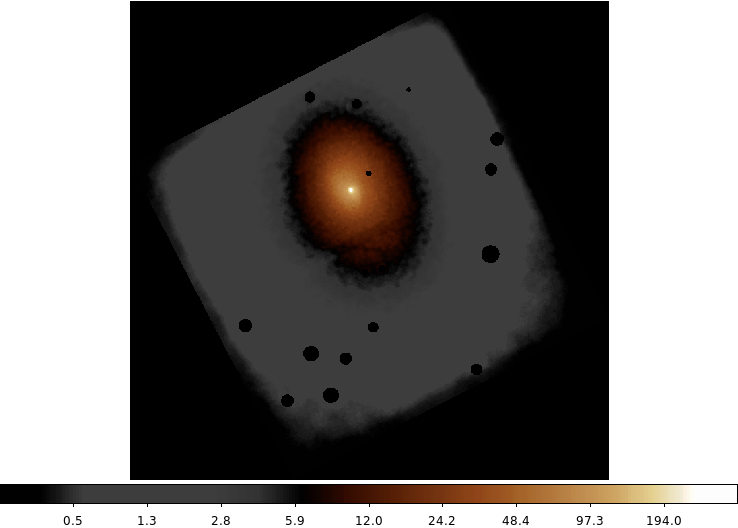

In [7]:
ds9 smoothed_image -scale log \
  -zoom to fit \
  -cmap load $ASCDS_CONTRIB/data/heart.lut \
  -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit

display < ds9_01.png

[1] 61234
[1]+  Done                    ds9 radii_min_250_counts -scale log -zoom to fit -cmap load $ASCDS_CONTRIB/data/20_colors.lut -saveimage png ds9_02.png


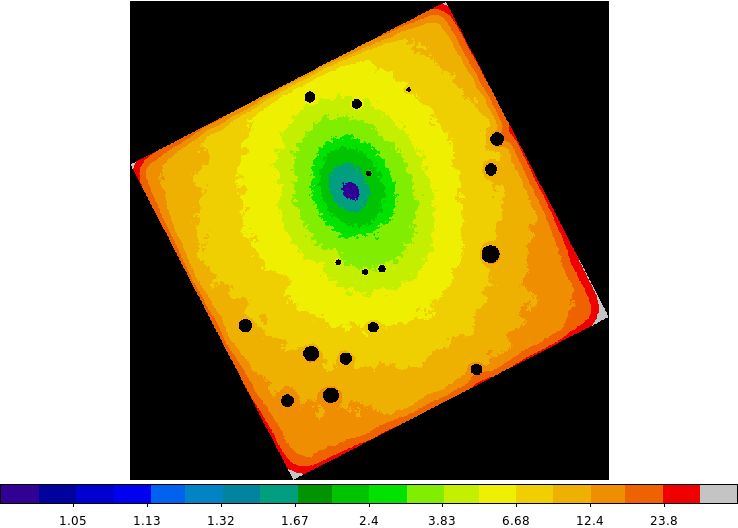

In [8]:
ds9 radii_min_250_counts -scale log \
  -zoom to fit \
  -cmap load $ASCDS_CONTRIB/data/20_colors.lut \
  -saveimage png ds9_02.png &
sleep 10
xpaset -p ds9 quit

display < ds9_02.png

## Using 

In [9]:
punlearn dmcoords
dmcoords radii_min_250_counts asol= op=cel ra=15:11:00.049 dec=+5:42:26.00 celfmt=hms verb=0 
pget dmcoords x y


4072.485893485075
3722.83455874064


In [10]:
evalpos radii_min_250_counts 15:11:00.049 +5:42:26.00

radii_min_250_counts	15:11:00.049 +5:42:26.00	5.5 [pixels]


In [11]:
dmstat abell2029_broad_thresh.img"[sky=circle(4072.485893485075,3722.83455874064,11)]" cen- sig- med-

EVENTS_IMAGE
    min:	0 	      @:	( 4075.5 3713.5 )
    max:	8 	      @:	( 4077.5 3727.5 )
   mean:	2.8444444444 
    sum:	256 
   good:	90 
   null:	54 


In [12]:
cat << EOM > p1.py
from pycrates import read_file
from ciao_contrib.runtool import dmstat
import numpy as np

img = read_file("radii_min_250_counts")

binsize=2.0

img_data = img.get_image().values
xlen = len(img_data[0])
ylen = len(img_data)

sky = img.get_transform("sky")

outfile = open("sample.out","w")

for jj in range(ylen):
   for ii in range(xlen):
       # Skip edges
       if np.isnan(img_data[jj,ii]) or img_data[jj,ii]>=1.1:
           continue
       xy = sky.apply( [[ii+1.0,jj+1.0]] )
       region = "circle({},{},{})".format( xy[0][0], xy[0][1], binsize*img_data[jj,ii])
       dmstat( "abell2029_broad_thresh.img[sky={}]".format(region), 
                     centroid=False, sigma=False, median=False )
       outfile.write("{}\t{}\t{}\n".format(xy[0][0], xy[0][1], dmstat.out_sum))

outfile.close()
EOM

python p1.py

In [13]:
head -10 sample.out

4205.5	3965.5	406
4205.5	3967.5	405
4207.5	3967.5	403
4191.5	3969.5	392
4195.5	3969.5	413
4197.5	3969.5	446
4199.5	3969.5	446
4201.5	3969.5	431
4203.5	3969.5	406
4209.5	3969.5	404


# Cleanup


In [14]:
/bin/rm -rf 4977
/bin/rm -f acisf* pcadf* 